In [14]:
import numpy as np
from itertools import product

def find_zeros(field, *ranges, **options):
    """Numerically approximate all zeros of a vector field within a box

    Each 'range' should have the form (x, xmin, xmax), where 'x' is one of the
    variables appearing in the vector field, and 'xmin' and 'xmax' are the
    bounds on that variables.

    Options:
        'intervals' - How many subintervals to use in each dimension (default
            20). If there are zeros that are very close together, you may need
            to increase this to find them. But be warned that the running time
            is roughly this to the n power, where n is the number of variables.
        'tolerance' - How close to approximate roots, roughly (default 1e-4)
        'maxiter' - Maximum number of iterations of Newton's Method to run for
            any one (potential) solution. This defaults to -2*log(tolerance).
            There usually isn't much harm in increasing this, unless there are
            many false hits.
        'round' - Round the components of the solutions to this many decimal
            places (default None, meaning do not round them at all)
    """

    # Initialization
    intervals = options.get("intervals", 20)
    tolerance = options.get("tolerance", 1e-5)
    maxiter = options.get("maxiter", int(round(-2*log(tolerance))))
    roundto = options.get("round", None)
    n = len(ranges)
    if len(field) != n:
        raise ValueError("Dimension of vector field is {}, but {} ranges "
                         "given".format(len(field), n))

    mins  = [xmin - (xmax - xmin)/intervals*tolerance for x, xmin, xmax in ranges]
    maxes = [xmax + (xmax - xmin)/intervals*tolerance for x, xmin, xmax in ranges]
    deltas = [(xmax - xmin) / intervals for xmin, xmax in zip(mins, maxes)]
    powers = [1 << i for i in range(n)]
    J = jacobian(field, [x for x, xmin, xmax in ranges])
    def dist(v, w):
        return sqrt(sum(((a - b) / d)**2 for a, b, d in zip(v, w, deltas)))

    # Set up the array of positive/negative signs of the vector field
    signs = np.zeros((intervals + 1,) * n, dtype=int)
    sranges = [srange(m, m + d*(intervals + 0.5), d) for m, d in zip(mins, deltas)]
    for vertex, index in zip(product(*sranges), product(range(intervals + 1), repeat=n)):
        v = field(*vertex)
        signs[index] = sum(powers[i] for i in range(n) if v[i] > 0)

    # Now search through that array for potential solutions
    solutions = []
    mask = int((1 << n) - 1)
    for index in product(range(intervals), repeat=n):
        indexpowers = list(zip(index, powers))
        all0s = 0
        all1s = mask
        for k in range(mask + 1):
            newindex = [i + (1 if k & p else 0) for i, p in indexpowers]
            vertex = signs[tuple(newindex)]
            all0s |= vertex
            all1s &= vertex
        if all0s & ~all1s == mask:
            # Now do Newton's method!
            v = vector(m + d*(i + 0.5) for i, m, d in zip(index, mins, deltas))
            for i in range(maxiter):
                previous_v = v
                v = v - J(*v).solve_right(field(*v))
                if dist(v, previous_v) < tolerance:
                    break
            else:
                warn("{} iterations reached without convergence for solution "
                     "{}".format(maxiter, v), RuntimeWarning)
            if solutions and min(dist(v, w) for w in solutions) < 2*tolerance:
                continue
            if not all(xmin <= x <= xmax for x, xmin, xmax in zip(v, mins, maxes)):
                continue
            solutions.append(vector(RDF, v))

    # A convenience: round to some number of decimal places, if requested
    if roundto is not None:
        solutions = [vector(round(x, roundto) for x in v) for v in solutions]
    return solutions

def plot_phase_portrait(field, x_range, y_range, init_conds, **options):
    """Plot a vector field, together with equilibrium points and trajectories

    'x_range' should have the form (x, xmin, xmax), and likewise for 'y_range'.
    'init_conds' should be a dictionary whose keys are the points that are to
        be used as initial conditions for trajectories. For each such initial
        condition, the value in the dictionary should be the range of t values
        over which to plot the trajectory starting at that initial point, such
        as srange(0, 20, 0.01) for t from 0 to 20 with a step size of 0.01. If
        you don't want to plot any trajectories, just use {} for this.

    Options:
        'field_color' - The color for vector field arrows (default "limegreen")
        'nullcline_colors' - A pair of colors for the two nullclines (default
            ("lightskyblue", "lightsalmon") )
        'eqpt_color' - The color for equilibrium points (default "darkmagenta")
        'trajectory_color' - The color for trajectories (default "red")
        Specifying None (or any False value) for any of the above will cause
        it to not be plotted at all. (Note that for the nullclines, this must
        be a tuple (None, None).)
    All other options are as for the various 'plot*' commands, and are passed
    directly on to them.
    """

    # Initialization
    x, xmin, xmax = x_range
    y, ymin, ymax = y_range
    field_color = options.pop("field_color", "limegreen")
    xnullcline_color, ynullcline_color = options.pop("nullcline_colors",
            ("lightskyblue", "lightsalmon"))
    eqpt_color = options.pop("eqpt_color", "darkmagenta")
    trajectory_color = options.pop("trajectory_color", "red")
    options.setdefault("frame", False)
    options.setdefault("axes", True)
    options.setdefault("aspect_ratio", "auto")
    options.setdefault("xmin", xmin)
    options.setdefault("xmax", xmax)
    options.setdefault("ymin", ymin)
    options.setdefault("ymax", ymax)
    p = Graphics()

    # Plot the vector field itself
    if field_color:
        options["color"] = field_color
        p += plot_vector_field(field, x_range, y_range, **options)

    # Plot the "vertical" nullcline
    if xnullcline_color:
        options["color"] = xnullcline_color
        p += implicit_plot(field[0] == 0, x_range, y_range, linewidth=2, **options)

    # Plot the "horizontal" nullcline
    if ynullcline_color:
        options["color"] = ynullcline_color
        p += implicit_plot(field[1] == 0, x_range, y_range, linewidth=2, **options)

    # Find and plot the equilibrium points
    if eqpt_color:
        options["color"] = eqpt_color
        equilibria = find_zeros(field, x_range, y_range)
        p += points(equilibria, size=50, **options)

    # Plot trajectories, if any initial conditions were given
    options["color"] = trajectory_color
    options["thickness"] = 2
    for init_cond, t_range in init_conds.items():
        solution = desolve_odeint(field, init_cond, t_range, [x, y])
        p += list_plot(solution, plotjoined=True, **options)

    return p


# Modeling dynamical systems using differential equations

Begin by choosing your ***state variables***. For example: 

$$\begin{aligned}
    H &= \text{number of snowshoe hares} \\
    L &= \text{number of Canadian lynx}
\end{aligned}$$


Then set up the ***differential equations***. The basic idea is, for each state variable $X$, write an equation of the form: 

$$ X' = [\text{rate of increase of } X] - [\text{rate of decrease of } X] $$


So for our example above with lynx and hares, we might say 
$$\begin{aligned}
    H' &= \text{[birth rate of hares]} - \text{[death rate of hares]} \\
    L' &= \text{[birth rate of lynx]} - \text{[death rate of lynx]}
\end{aligned}$$


For this example, we'll use the following assumptions: 
- In the absence of predators, the snowshoe hare population grows at a per-capita rate of 30% per year. 
- Each lynx consumes hares at a rate that's proportional to the hare population, with a proportionality constant of 0.02. 
- The birth rate of the lynx is proportional to how much food they're consuming, with a proportionality constant of 0.5. 
- The lynx die at a per-capita rate of 20% per year. 


This yields the following differential equations: 

$$\begin{cases}
    H' = 0.3H - 0.02HL \\
    L' = 0.5 \cdot 0.02HL - 0.2L
\end{cases}$$


**Important point:** We can think of a differential equation as a **function**, that takes the state variables as **inputs**, and gives the rates of change as **outputs**. 


For a single-variable differential equation, this is as simple as $X' = f(X)$. 


For example, for the following differential equation (an example of the logistic model): 
$$ X' = 0.2X \cdot \left( 1 - \tfrac{X}{500} \right) $$
the function is $f(X) = 0.2X \cdot \big( 1 - \frac{X}{500} \big)$. 

That is, the function is just the right-hand side of the differential equation. 

For a multi-variable differential equation like our lynx-and-hares example above: 
$$\begin{cases}
    H' = 0.3H - 0.02HL \\
    L' = 0.5 \cdot 0.02HL - 0.2L , 
\end{cases}$$


we begin by rewriting it in “vector form” as follows: 
$$ \begin{bmatrix} H' \\ L' \end{bmatrix} = \begin{bmatrix} 0.3H - 0.02HL \\ 0.01HL - 0.2L \end{bmatrix} $$

So if we want to think of this differential equation as a **function**, that function is 
$$ f( \begin{bmatrix} H \\ L \end{bmatrix} ) = \begin{bmatrix} 0.3H - 0.02HL \\ 0.01HL - 0.2L \end{bmatrix} $$


To begin to visualize how models behave, we first think of the ***state space***: 


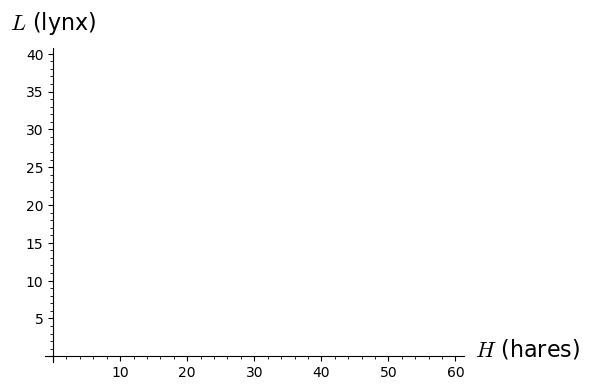

In [1]:
p = point([(0,0), (60,40)], size=0)
p.show(axes_labels=("$H$ (hares)", "$L$ (lynx)"), figsize=6)


This is a space in which each state variable gets its own axis, so that each ***state*** the system can be in corresponds to a *point in the state space*. 


For each state (point) in the state space, we can plug the corresponding values of $H$ and $L$ into the differential equations, and we get a ***change vector*** $\left[ \begin{smallmatrix} H' \\ L' \end{smallmatrix} \right]$. 

If we draw the change vector at each point, we get the ***vector field*** of the differential equations: 


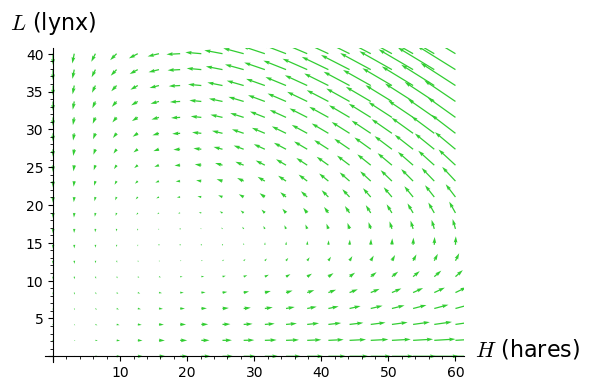

In [2]:
vectorfield(H, L) = (0.3*H - 0.02*H*L, 0.01*H*L - 0.2*L)
p = plot_vector_field(vectorfield, (H, 0, 60), (L, 0, 40), color="limegreen")
p.show(frame=False, axes_labels=("$H$ (hares)", "$L$ (lynx)"))


Think back briefly to what we said about how a differential equation ***is* a function**: it takes a *state* as input, and gives a *change vector* as output. 


That is, its **domain** is the **state space** of the model, and its **codomain** is the space of all possible change vectors, which we call the **tangent space** of the model. 


In short, it's a function that can be described by 
$$ f: [\text{state space}] \to [\text{tangent space}] $$

In LS 30A, this was just an abstract concept. This quarter, we will rely on this concept a lot more. 

From the vector field, it's easy to see the behavior of the system: if the system starts at the state $\left[ \begin{smallmatrix} H \\ L \end{smallmatrix} \right] = \left[ \begin{smallmatrix} 30 \\ 5 \end{smallmatrix} \right]$ as shown below, it will move through the state space by following the change vectors. 


In [3]:
def trajectory():
    vectorfield(H, L) = (0.3*H - 0.02*H*L, 0.01*H*L - 0.2*L)
    initial_state = (30, 5)
    t_range = srange(0, 50, 0.1)
    solution = desolve_odeint(vectorfield, initial_state, t_range, [H, L])

    vector_field_plot = plot_vector_field(vectorfield, (H, 0, 60), (L, 0, 40), color="limegreen")
    vector_field_plot += point([initial_state], color="black", size=40)
    trajectory_plot = list_plot(solution, plotjoined=True, color="red", thickness=2)

    @interact(show_trajectory=checkbox(False, label="Show trajectory"))
    def _(show_trajectory):
        if show_trajectory:
            p = vector_field_plot + trajectory_plot
        else:
            p = vector_field_plot
        p.show(frame=False, axes_labels=("$H$ (hares)", "$L$ (lynx)"))

trajectory()


Interactive function <function trajectory.<locals>._ at 0x7f16052ad620> with 1 widget
  show_trajectory: Check…

The resulting curve is called a ***trajectory*** of the system (shown in red above). It's a visual representation of a ***solution*** of the differential equations. 

<span style="font-size: 60%">(Remember that there's another way to visualize a solution of the differential equations: ***time series***. The time series plots of a solution are graphs of the state variables as functions of time.</span> 

From looking at the vector field, it's easy to visualize where the trajectory goes. But how do we compute this trajectory? That is, how do we compute the solution of the differential equation? 


Most of the time, it's **impossible** to compute it exactly using just algebra and calculus techniques. (That is, it's impossible to come up with a formula for $H(t)$ and $L(t)$ as functions of time, $t$.) 


So instead, we approximate them using ***Euler's method***. 


### Euler's method: $\quad [\text{next state}] \approx [\text{current state}] + \Delta t \cdot [\text{change vector}]$


In [4]:
def eulers_method():
    vectorfield(H, L) = (0.3*H - 0.02*H*L, 0.01*H*L - 0.2*L)
    initial_state = vector((30, 5))
    t_range = srange(0, 50, 0.1)
    solution = desolve_odeint(vectorfield, initial_state, t_range, [H, L])

    state_space_plot = point([initial_state], color="black", size=40)
    vector_field_plot = plot_vector_field(vectorfield, (H, 0, 60), (L, 0, 40), color="limegreen")
    trajectory_plot = list_plot(solution, plotjoined=True, color="red", thickness=2)

    @interact(iterations=slider(srange(0, 41) + ["Many"], label="# of steps"), 
              delta_t=slider([RDF(a) for a in [1, 0.5, 0.2, 0.1, 0.05, 0.01]], label=r"$\Delta t$"), 
              show_actual=checkbox(False, label="Show actual trajectory"))
    def _(iterations, delta_t, show_actual):
        p = state_space_plot + vector_field_plot
        states = [initial_state]
        if iterations == "Many":
            iterations = floor(t_range[-1] / delta_t)
        for i in range(iterations):
            states.append(states[-1] + delta_t * vectorfield(*states[-1]))
        p += list_plot(states, color="black", size=35)
        p += list_plot(states, plotjoined=True, color="blue", thickness=2)
        if show_actual:
            p += trajectory_plot
        p.show(xmin=0, xmax=60, ymin=0, ymax=40, frame=False, axes_labels=("$H$ (hares)", "$L$ (lynx)"))

eulers_method()


Interactive function <function eulers_method.<locals>._ at 0x7f15e41a01e0> with 3 widgets
  iterations: Select…

So we can use Euler's method to numerically approximate solutions (trajectories and/or time series) of a differential equation. This is called ***simulation***. 

But another *very important* tool we can use to study the behavior of a model is to analyze its ***equilibrium points***. 

# Equilibrium points

**Definition:** A differential equation $\left[ \begin{smallmatrix} X' \\ Y' \\ \vdots \end{smallmatrix} \right] = f( \left[ \begin{smallmatrix} X \\ Y \\ \vdots \end{smallmatrix} \right] )$ has an ***equilibrium point*** at the state (point) $\left[ \begin{smallmatrix} X^* \\ Y^* \\ \vdots \end{smallmatrix} \right]$ if the change vector is exactly 0 at that point. That is, if 
$$ f( \left[ \begin{smallmatrix} X^* \\ Y^* \\ \vdots \end{smallmatrix} \right] ) = \left[ \begin{smallmatrix} 0 \\ 0 \\ \vdots \end{smallmatrix} \right] $$


So, to find equilibrium points of a differential equation, just set the right-hand side of each equation to 0, and solve. (If there are multiple variables and multiple equations, you have to *solve simultaneously*.) 

But remember, **not all equilibrium points are created equal**. 

Some equilibrium points are ***stable***, some are ***unstable***. And even within these broad classifications, there can be different types. 

One significance of equilibrium points is that the *stable equilibrium points* often dictate the ***long term behavior*** of the system. 


**Example:** The Allee effect model

$$ X' = 0.02X \cdot \big( 1 - \tfrac{X}{250} \big) \cdot \big( \tfrac{X}{40} - 1 \big) $$

The equilibrium points at $X = 0$ and $X = 250$ are stable. The one at $X = 40$ is unstable. 


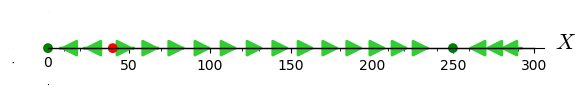

In [5]:
vectorfield(X) = 0.02*X*(1 - X/250)*(X/40 - 1)
df = diff(vectorfield, X)
xmin, xmax = 0, 300
plotpoints = 20
eqpts = [expr.rhs() for expr in solve(vectorfield, X)]

delta_x = (xmax - xmin) / plotpoints
x_values = srange(xmin + delta_x/2, xmax, delta_x)
vectors = [vectorfield(X0) for X0 in x_values]
maxsize = max([abs(vec) for vec in vectors])
p = plot(0, (X, xmin, xmax), color="black", zorder=10)
p += line([(-delta_x,-1.4), (-delta_x,1.4)], color="white", thickness=50, zorder=5)
if xmin <= 0 <= xmax:
    p += text("0", (0, -0.6), color="black", zorder=10)
for X0, vec in zip(x_values, vectors):
    if min([abs(X0 - eqpt) for eqpt in eqpts]) < delta_x / 5:
        continue
    vec = vector((vec / maxsize * delta_x * 0.9, 0))
    p += plot(vec, start=(X0,0), color="limegreen")
for eqpt in eqpts:
    stability = df(eqpt)
    color = "green" if stability < 0 else "red" if stability > 0 else "orange"
    p += point([(eqpt, 0)], color=color, size=50, zorder=10)
p.show(aspect_ratio=(xmax - xmin)/20, axes_labels=("$X$", ""))

For higher dimensional systems, there are several types of stable and unstable equilibrium points: 


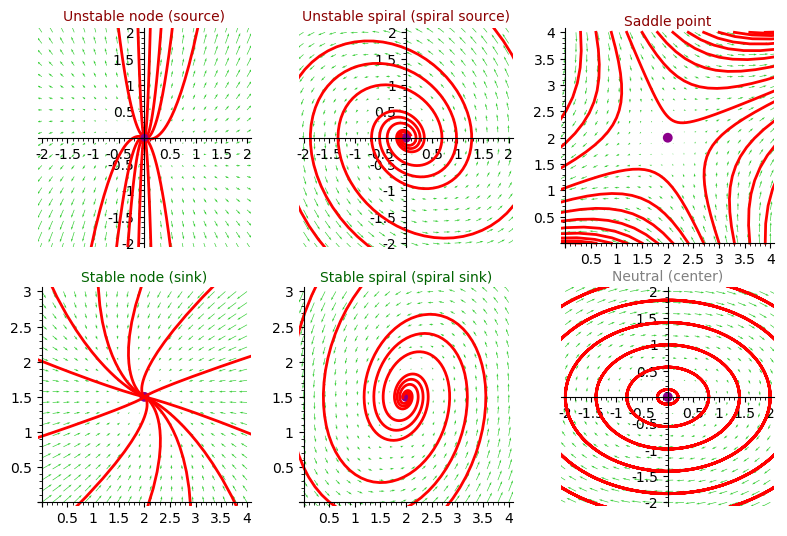

In [15]:
t_range = srange(0, 20, 0.1)
t_range_short = srange(0, 10, 0.1)
init_conds = {(3*cos(theta) + 2, 3*sin(theta) + 1.5): t_range for theta in srange(pi/12, 2*pi, pi/6)}
field(X, Y) = (-2*(X-2) - (Y-1.5), -2*(Y-1.5))
sink = plot_phase_portrait(field, (X, 0, 4), (Y, 0, 3), init_conds, nullcline_colors=(None, None))
sink += text("Stable node (sink)", (2, 3.2), color="darkgreen")
sink.set_axes_range(0, 4, 0, 3)

init_conds = {(3*cos(theta) + 2, 3*sin(theta) + 1.5): t_range for theta in srange(pi/6, pi, pi/3)}
field(X, Y) = (-(Y-1.5), (X-2) - 0.4*(Y-1.5))
spiralsink = plot_phase_portrait(field, (X, 0, 4), (Y, 0, 3), init_conds, nullcline_colors=(None, None))
spiralsink += text("Stable spiral (spiral sink)", (2, 3.2), color="darkgreen")
spiralsink.set_axes_range(0, 4, 0, 3)

init_conds = {(0.1*cos(theta), 0.1*sin(theta)): t_range_short for theta in srange(pi/12, 2*pi, pi/6)}
field(X, Y) = (X, 0.5*X + 2*Y)
source = plot_phase_portrait(field, (X, -2, 2), (Y, -2, 2), init_conds, nullcline_colors=(None, None))
source += text("Unstable node (source)", (0, 2.3), color="darkred")
source.set_axes_range(-2, 2, -2, 2)

init_conds = {(0.1*cos(theta), 0.1*sin(theta)): t_range for theta in srange(pi/6, pi, pi/3)}
field(X, Y) = (-Y, X + 0.4*Y)
spiralsource = plot_phase_portrait(field, (X, -2, 2), (Y, -2, 2), init_conds, nullcline_colors=(None, None))
spiralsource += text("Unstable spiral (spiral source)", (0, 2.3), color="darkred")
spiralsource.set_axes_range(-2, 2, -2, 2)

init_conds = {(x0, 0): t_range for x0 in srange(0.2, 3.5, 0.6)}
field(X, Y) = (2*Y, -X)
center = plot_phase_portrait(field, (X, -2, 2), (Y, -2, 2), init_conds, nullcline_colors=(None, None))
center += text("Neutral (center)", (0, 2.3), color="gray")
center.set_axes_range(-2, 2, -2, 2)

init_conds = {(x0, 0): t_range_short for x0 in srange(0.3, 4, 0.3)}
init_conds.update({(x0, 4): t_range_short for x0 in srange(0.3, 4, 0.3)})
field(X, Y) = ((X-2) + (Y-2), (X-2) - (Y-2))
saddle = plot_phase_portrait(field, (X, 0, 4), (Y, 0, 4), init_conds, nullcline_colors=(None, None))
saddle += text("Saddle point", (2, 4.2), color="darkred")
saddle.set_axes_range(0, 4, 0, 4)

bigpicture = graphics_array([[source, spiralsource, saddle], [sink, spiralsink, center]])
bigpicture.show(figsize=8)


Recall that, by the end of LS 30A, we had no way, other than simulation, to distinguish between the three “rotating” types of equilibrium points: stable spiral, center, and unstable spiral. 

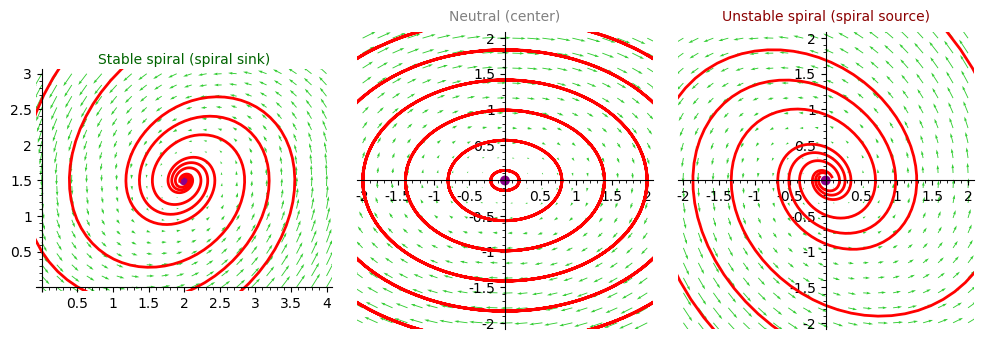

In [16]:
spirals = graphics_array([[spiralsink, center, spiralsource]])
spirals.show(aspect_ratio=1, figsize=10)


Even with simulation, it's sometimes very difficult to distinguish between an equilibrium point that's a stable spiral and one that's an unstable spiral! 


Is the equilibrium point below a stable spiral, or an unstable one? The trajectory is spiraling in towards the equilibrium point... *at first*. But does it keep spiralling inward, and eventually “fill in” that little hole that we see? Or would a trajectory that starts very close to the equilibrium point actually spiral *outward* a little bit? 


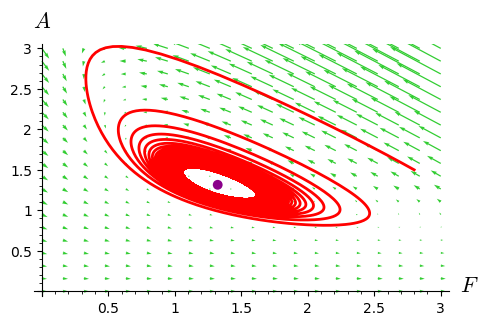

In [17]:
# Parameters:
p = 0.526  # Rate of production of fructose-6-phosphate
c = 0.4    # Rate of consumption of ADP
k = 0.23   # Reaction rate constant

vectorfield(F, A) = (p - k*F*A^2, k*F*A^2 - c*A)

t_range = srange(0, 3000, 0.1)
ics = {(2.8, 1.5): t_range}
p = plot_phase_portrait(vectorfield, (F, 0, 3), (A, 0, 3), ics, nullcline_colors=(None, None))
p.show(axes_labels=("$F$", "$A$"), figsize=5)


This is a **major** unanswered question for us, which we will finally solve *near the end of this quarter!* 

Finally, if a differential equation has a parameter in it, say $r$, then we can vary that parameter and see how the behavior of the system changes. 

**Definition:** A ***bifurcation*** occurs when varying a *parameter* of the model causes a change in the overall behavior of the model. Usually, this means  a change in the number and/or stability of equilibrium points. 

This quarter, we will (*very soon!*) learn about some new types of bifurcations. 

In [18]:
@interact(k=slider(2, 14, 0.1, default=5, label="Carrying capacity"))
def spruce_budworm(k):
    vectorfield(X) = 0.55*X*(1 - X/k) - X^2/(1 + X^2)
    df = diff(vectorfield, X)
    xmin, xmax = 0, 14
    plotpoints = 20
    delta_x = (xmax - xmin) / plotpoints
    eqpts = [expr.rhs().n() for expr in solve(vectorfield, X)]
    eqpts = [real(x0) for x0 in eqpts if abs(imag(x0)) < 1E-12 and xmin <= real(x0) <= xmax]

    p = plot(0, (X, xmin, xmax), color="black", zorder=10)
    p += line([(-delta_x,-1.4), (-delta_x,1.4)], color="white", thickness=50, zorder=5)
    if xmin <= 0 <= xmax:
        p += text("0", (0, -0.6), color="black", zorder=10)
    for eqpt in eqpts:
        stability = df(eqpt)
        color = "green" if stability < 0 else "red" if stability > 0 else "orange"
        p += point([(eqpt, 0)], color=color, size=50, zorder=10)
    p.show(aspect_ratio=(xmax - xmin)/20, axes_labels=("$X$", ""))

Interactive function <function spruce_budworm at 0x7f15e3ec2d90> with 1 widget
  k: TransformFloatSlider(value…